<a href="https://colab.research.google.com/github/AnastasiaZAYU/ml-fundamentals-labs/blob/main/03-Neural-Networks-Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Виконати наступне:
1. **Повнозв'язані нейронні мережі.**
Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняйте з одержаними раніше.

2. **Згорткові нейронні мережі.**
Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

3. **Рекурентні нейронні мережі.**
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі. Результати порівняйте з одержаними раніш.

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

import zipfile
import os
import shutil
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Повнозв'язані нейронні мережі

### Завантаження та очишення даних

In [29]:
df=pd.read_csv('advertising_ef.csv')
df=df.dropna()

### Вивід назв колонок

In [30]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Gender', 'Clicked on Ad'],
      dtype='object')

### Відокремлення target та стандартизація даних

In [31]:
X = df[['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Gender']]
y = np.array(df[['Clicked on Ad']])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [33]:
scaler = MinMaxScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

### Побудова моделі

In [34]:
model_1 = keras.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(x_train.shape[-1], )),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation="sigmoid"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
    ])

In [35]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1536      
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 35585 (139.00 KB)
Trainable params: 35073 (137.00 KB)
Non-trainable params: 512 (2.00 KB)
________________

### Навчання моделі

In [36]:
model_1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [39]:
history = model_1.fit(x_train, y_train,
                      validation_data=(x_test, y_test),
                      epochs=30, batch_size=128)

Epoch 1/30
6/6 [==============================] - 0s 73ms/step - loss: 0.0706 - accuracy: 0.9781 - val_loss: 0.4510 - val_accuracy: 0.7619
Epoch 2/30
6/6 [==============================] - 0s 42ms/step - loss: 0.0718 - accuracy: 0.9752 - val_loss: 0.4327 - val_accuracy: 0.8129
Epoch 3/30
6/6 [==============================] - 0s 38ms/step - loss: 0.0778 - accuracy: 0.9738 - val_loss: 0.4500 - val_accuracy: 0.7551
Epoch 4/30
6/6 [==============================] - 0s 94ms/step - loss: 0.0690 - accuracy: 0.9767 - val_loss: 0.4331 - val_accuracy: 0.7959
Epoch 5/30
6/6 [==============================] - 1s 97ms/step - loss: 0.0696 - accuracy: 0.9781 - val_loss: 0.4031 - val_accuracy: 0.8673
Epoch 6/30
6/6 [==============================] - 1s 106ms/step - loss: 0.0714 - accuracy: 0.9781 - val_loss: 0.3784 - val_accuracy: 0.9116
Epoch 7/30
6/6 [==============================] - 0s 60ms/step - loss: 0.0733 - accuracy: 0.9767 - val_loss: 0.3521 - val_accuracy: 0.9320
Epoch 8/30
6/6 [==========

In [40]:
predictions = model_1.predict(x_test)
print(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

10/10 [==============================] - 0s 3ms/step
1.0


## 2. Згорткові нейронні мережі

### Зчитування датасету

In [127]:
zip_path = '/content/archive.zip'

extracted_path = '/content/extracted_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

train_path = '/content/train'
test_path = '/content/test'
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

source_train_path = os.path.join(extracted_path, 'PandasBears', 'Train')
source_test_path = os.path.join(extracted_path, 'PandasBears', 'Test')

def copy_files(source, destination):
    for root, dirs, files in os.walk(source):
        for file in files:
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, source)
            destination_file_path = os.path.join(destination, relative_path)
            os.makedirs(os.path.dirname(destination_file_path), exist_ok=True)
            shutil.copy(file_path, destination_file_path)

copy_files(os.path.join(source_train_path, 'Pandas'), os.path.join(train_path, 'Pandas'))
copy_files(os.path.join(source_train_path, 'Bears'), os.path.join(train_path, 'Bears'))
copy_files(os.path.join(source_test_path, 'Pandas'), os.path.join(test_path, 'Pandas'))
copy_files(os.path.join(source_test_path, 'Bears'), os.path.join(test_path, 'Bears'))

### Зчитування тренувальних даних

In [ ]:
data = "/content/train"
data = pathlib.Path(data).with_suffix('')
image_bears = list(data.glob('Bears/*.jpeg'))
image_pandas = list(data.glob('Pandas/*.jpeg'))
print(image_bears, image_pandas)

[PosixPath('/content/train/Bears/172.jpeg'), PosixPath('/content/train/Bears/118.jpeg'), PosixPath('/content/train/Bears/219.jpeg'), PosixPath('/content/train/Bears/215.jpeg'), PosixPath('/content/train/Bears/141.jpeg'), PosixPath('/content/train/Bears/231.jpeg'), PosixPath('/content/train/Bears/93.jpeg'), PosixPath('/content/train/Bears/228.jpeg'), PosixPath('/content/train/Bears/115.jpeg'), PosixPath('/content/train/Bears/193.jpeg'), PosixPath('/content/train/Bears/92.jpeg'), PosixPath('/content/train/Bears/105.jpeg'), PosixPath('/content/train/Bears/36.jpeg'), PosixPath('/content/train/Bears/196.jpeg'), PosixPath('/content/train/Bears/192.jpeg'), PosixPath('/content/train/Bears/123.jpeg'), PosixPath('/content/train/Bears/12.jpeg'), PosixPath('/content/train/Bears/82.jpeg'), PosixPath('/content/train/Bears/164.jpeg'), PosixPath('/content/train/Bears/37.jpeg'), PosixPath('/content/train/Bears/211.jpeg'), PosixPath('/content/train/Bears/16.jpeg'), PosixPath('/content/train/Bears/47.jpe

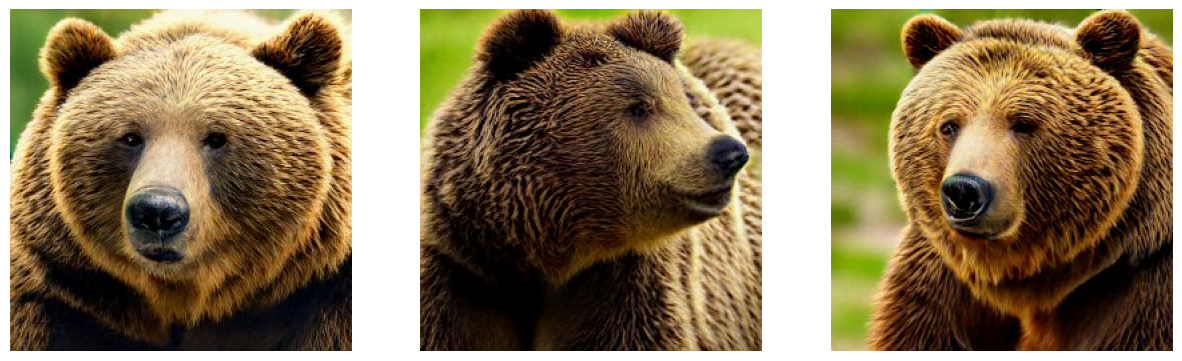

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img_path in enumerate(image_bears[:3]):
  img = mpimg.imread(str(img_path))
  axes[i].imshow(img)
  axes[i].axis('off')
plt.show()


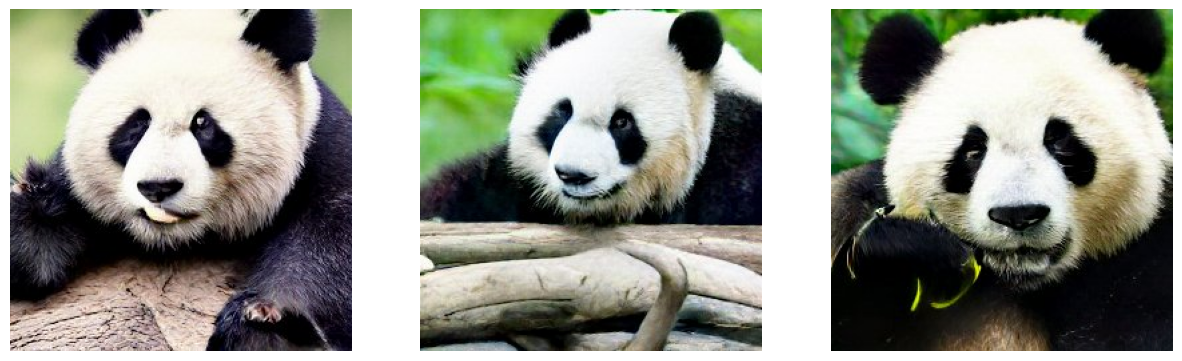

In [156]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img_path in enumerate(image_pandas[:3]):
  img = mpimg.imread(str(img_path))
  axes[i].imshow(img)
  axes[i].axis('off')
plt.show()

In [130]:
batch_size = 32
image_height = 180
image_width = 180

In [132]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", input_shape=(image_height, image_width, 3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ])

In [134]:
train = keras.utils.image_dataset_from_directory(data, validation_split=0.2, subset="training", seed=123, image_size=(image_height, image_width), batch_size=32)

Found 500 files belonging to 2 classes.
Using 400 files for training.


In [135]:
class_names = train.class_names
print(class_names)

['Bears', 'Pandas']


In [136]:
val = keras.utils.image_dataset_from_directory(data, validation_split=0.2, subset="validation", seed=123, image_size=(image_height, image_width), batch_size=batch_size)

Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [137]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

### Побудова моделі

In [138]:
model_2 = keras.Sequential([
  data_augmentation,
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='tanh'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='tanh'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation='sigmoid'),
  keras.layers.Dense(2, name="outputs")
])

In [139]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_3 (Bat  (None, 45, 45, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)      

### Навчання моделі

In [142]:
model_2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [144]:
model_2.fit(train, validation_data = val, epochs=4)

Epoch 1/4
13/13 [==============================] - 14s 1s/step - loss: 0.0465 - accuracy: 0.9875 - val_loss: 0.4429 - val_accuracy: 0.8300
Epoch 2/4
13/13 [==============================] - 11s 802ms/step - loss: 0.0065 - accuracy: 0.9975 - val_loss: 1.2941 - val_accuracy: 0.6600
Epoch 3/4
13/13 [==============================] - 12s 916ms/step - loss: 0.0042 - accuracy: 0.9975 - val_loss: 1.8860 - val_accuracy: 0.5600
Epoch 4/4
13/13 [==============================] - 12s 962ms/step - loss: 5.5669e-04 - accuracy: 1.0000 - val_loss: 0.7756 - val_accuracy: 0.7800


1/1 [==============================] - 0s 72ms/step
tf.Tensor([0.9987472  0.00125272], shape=(2,), dtype=float32)
This image most likely belongs to Bears with a 99.87 percent confidence.


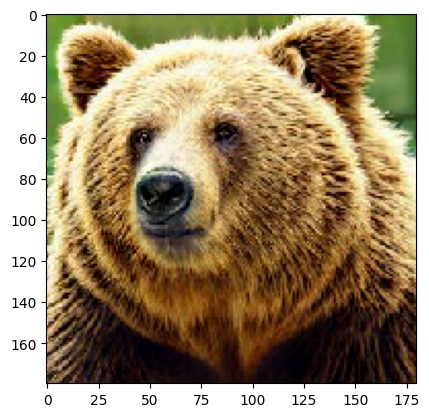

In [146]:
image_size = (180, 180)
image = tf.keras.preprocessing.image.load_img( "/content/test/Bears/296.jpeg", target_size=image_size)
plt.imshow(image)

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])

input_arr = input_arr.astype('float32') / 255.

predictions = model_2.predict(input_arr)
score = tf.nn.softmax(predictions[0])
print(score)
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))


## 3. Рекурентні нейронні мережі

### Завантаження та очищення датасету
https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews

In [107]:
df=pd.read_csv('Restaurant_reviews.csv')
df=df.dropna()

### Вивід назв колонок та видалення зайвих

In [108]:
df.columns

Index(['Restaurant', 'Reviewer', 'Review', 'Rating'], dtype='object')

In [109]:
df=df.drop(['Restaurant','Reviewer'],axis=1)
df = df[df['Rating'] != 4]

### Зменшення кількості класів, шляхом їх об'єднання

In [110]:
df['Rating'].replace({2: 1, 3: 1},inplace=True)
Counter( df['Rating'])

Counter({5: 3826, 1: 3611})

### Очищення тексту регулярними виразами

In [111]:
def clean_text(text):
  stop_words = set(stopwords.words("english"))
  stop_words.update(['restaurant','place','food','taste','service','ordered','order','one','good'])
  text = text.lower()
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub('\n\S+', '', text)
  text = re.sub('\s{2,}', " ", text)
  text = ' '.join([word for word in text.split(' ') if word not in stop_words])
  return text

In [112]:
df['Review']=df['Review'].apply(clean_text)

In [113]:
print(df)

                                                 Review  Rating
0     ambience quite saturday lunch cost effective s...       5
1     ambience pleasant evening prompt experience so...       5
2     must try great great ambience thnx pradeep sub...       5
3     soumen das arun great guy behavior sincerety c...       5
4     goodwe kodi drumsticks basket mutton biryani t...       5
...                                                 ...     ...
9804  amazing always go want chinese favourite crab ...       5
9805  never fan chinese visited chinese pavilionbanj...       5
9806  visited friends immediately blown away quality...       5
9807  im going cut chase excellent must say honey ch...       5
9808  madhumathi mahajan well start nice courteous s...       1

[7437 rows x 2 columns]


### Розбиття датасету на тренувальні і тестові дані

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.30, random_state=23)

In [115]:
vocab_size = 10000
oov_token = ""
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [116]:
x_train_sequences = tokenizer.texts_to_sequences(X_train)
x_test_sequences = tokenizer.texts_to_sequences(X_test)

In [117]:
max_length = 100
padding_type = "post"
trunction_type="post"
x_train = keras.utils.pad_sequences(x_train_sequences,maxlen=max_length, padding=padding_type, truncating=trunction_type)
x_test = keras.utils.pad_sequences(x_test_sequences,maxlen=max_length, padding=padding_type, truncating=trunction_type)

### Використовуємо GloVe word embeddings

In [118]:
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

--2023-12-16 10:29:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-16 10:29:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-16 10:29:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [119]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [120]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [121]:
word_index = tokenizer.word_index

In [122]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Побудова моделі

In [123]:
model_3 = keras.Sequential([
    keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=max_length,  weights=[embedding_matrix], input_length=max_length, trainable=False),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])

### Навчання моделі

In [124]:
model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000001),
                loss="binary_crossentropy",
                metrics=['accuracy'])

In [125]:
model_3.fit(x_train, y_train,
            epochs=30,
            validation_data=(x_test, y_test),
            batch_size=128)

Epoch 1/30
41/41 [==============================] - 45s 223ms/step - loss: 0.6912 - accuracy: 0.4697 - val_loss: 0.6906 - val_accuracy: 0.4736
Epoch 2/30
41/41 [==============================] - 9s 227ms/step - loss: 0.6910 - accuracy: 0.4811 - val_loss: 0.6904 - val_accuracy: 0.4736
Epoch 3/30
41/41 [==============================] - 12s 305ms/step - loss: 0.6909 - accuracy: 0.4811 - val_loss: 0.6903 - val_accuracy: 0.4736
Epoch 4/30
41/41 [==============================] - 7s 182ms/step - loss: 0.6908 - accuracy: 0.4811 - val_loss: 0.6902 - val_accuracy: 0.4736
Epoch 5/30
41/41 [==============================] - 9s 225ms/step - loss: 0.6906 - accuracy: 0.4811 - val_loss: 0.6900 - val_accuracy: 0.4736
Epoch 6/30
41/41 [==============================] - 8s 192ms/step - loss: 0.6905 - accuracy: 0.4811 - val_loss: 0.6899 - val_accuracy: 0.4736
Epoch 7/30
41/41 [==============================] - 9s 218ms/step - loss: 0.6904 - accuracy: 0.4813 - val_loss: 0.6898 - val_accuracy: 0.4736
Epoc

In [126]:
loss, accuracy = model_3.evaluate(x_test, y_test)
print('Test accuracy :', accuracy)

70/70 [==============================] - 1s 19ms/step - loss: 0.6867 - accuracy: 0.4740
Test accuracy : 0.4740143418312073
